# Computation of the virtual orbitals and check of the completeness relation for $N_2$

We compute the virtual orbitals of the $N_2$ molecule and evalute the maximum energy sampled by the system. Then we use this basis to express the occupied orbitals of the same molecule subjected to a static electric field.

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'virtual-orbitals/'
outputpathon = 'virtual-orbitals-on/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

## Computation of the virtual orbitals (cubic code)

### Generation of the input files

In [3]:
# The computation with 320 virtual states is performed only for rVal = 7.0
numVirt=[16,32,64,128,256]#,320]
rVal = [7.0,9.0]

In [4]:
for r in rVal:
    inp={'dft':
         {'rmult': [r, 9.0],
         'itermax_virt' : 100},
         'output': {'orbitals' : 'binary'}}
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in numVirt:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_'+str(r))

### Execution of the input files

In [5]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
for r in rVal:
    code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_7.0 -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_9.0 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


### Data Analysis

We discuss the results of these computations. First, we read all the log files and organize them in the lists Data

In [6]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/'+str('log-Rmult_')+str(r)+str('*') 
    logs = !ls $spath
    print logs
    Data.append([lf.Logfile(l) for l in logs])
%cd ..
# sort the Data list in the right order, with respect to the number of virtual orbitals
for r in range(len(rVal)):
    listnorbs=[len(l.evals[0][0]) for l in Data[r]]
    ipiv=np.argsort(listnorbs)
    Data[r]=[Data[r][i] for i in ipiv]
# The first index of Data selects the value of rmult, the second one the number of virtual orbitals.

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-Rmult_7.0_numVirt_128.yaml', 'log/log-Rmult_7.0_numVirt_16.yaml', 'log/log-Rmult_7.0_numVirt_256.yaml', 'log/log-Rmult_7.0_numVirt_320.yaml', 'log/log-Rmult_7.0_numVirt_32.yaml', 'log/log-Rmult_7.0_numVirt_64.yaml']
['log/log-Rmult_9.0_numVirt_128.yaml', 'log/log-Rmult_9.0_numVirt_16.yaml', 'log/log-Rmult_9.0_numVirt_256.yaml', 'log/log-Rmult_9.0_numVirt_32.yaml', 'log/log-Rmult_9.0_numVirt_64.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We chose a value of the box and compute the maximum energy in function of the number of virtual orbitals

rmult =  7.0
[0.20607565321249799, 0.31759846548686599, 0.53072198145630001, 0.80348080145203205, 1.2687490505821, 1.4910360117775301]


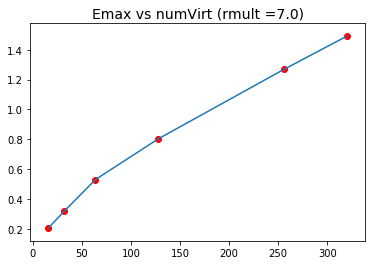

In [7]:
r = 0
print 'rmult = ', rVal[r]

Emax=[]
nVirt=[]
for n in Data[r]:
    nVirt.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Emax)

plt.plot(nVirt,Emax)
plt.scatter(nVirt,Emax, color='r')
plt.title('Emax vs numVirt (rmult ='+str(rVal[r])+')',fontsize=14)
plt.show()

## Expansion of the perturbed KS orbitals (cubic code)

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e^{-2}$ both in the $z$ and $x$ directions. We perform the computation using the highest value of computed virtual orbitals.
First of all we we build the input file, perform the computations and read the results.

### Generation of the input files and execution of the computations

In [10]:
for r in rVal:
    psip_Ex = '../static-field/log/data-Ex_1em2_rmult_'+str(r) #relative path starting from outputpath
    psip_Ez = '../static-field/log/data-Ez_1em2_rmult_'+str(r)
    inpEx={'dft':
           {'rmult': [r, 9.0],
            'norbv': -numVirt[-1],
            'itermax_virt' : 1},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ex}}
    inpEz={'dft':
           {'rmult': [r, 9.0],
            'norbv': -numVirt[-1],
            'itermax_virt' : 1},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ez}}
    InpnameEx = 'CR_Ex_rmult_'+str(r)+'_numVirt_'+str(numVirt[-1])
    InpnameEz = 'CR_Ez_rmult_'+str(r)+'_numVirt_'+str(numVirt[-1])

    Yaml.dump(inpEz,outputpath + InpnameEz + '.yaml')
    Yaml.dump(inpEx,outputpath + InpnameEx + '.yaml')
    # execute the input files
    %cd $outputpath
    code.run(name=InpnameEx,skip=True,outdir='./log/')
    code.run(name=InpnameEz,skip=True,outdir='./log/')
    %cd ../

# read the data. First index for the value of rmult, second index for the direction of the field
CR_data = []
%cd $outputpath
for r in rVal:
    spath = 'log/'+str('log-CR_E*_rmult_')+str(r)+str('*') 
    logs = !ls $spath
    print logs
    CR_data.append([lf.Logfile(l) for l in logs])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_numVirt_256 -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_numVirt_256 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_9.0_numVirt_256 -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_9.0_numVirt_256 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-CR_Ex_rmult_7.0_numVirt_256.yaml', 'log/log-CR_Ez_rmult_7.0_numVirt_256.yaml']
['log/log-CR_Ex_rmult_9.0_numVirt_256.yaml', 'log/log-CR_Ez_rmult_9.0_numVirt_256.ya

### Data analysis

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

no_occ 5 n_vrt 256
psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]
no_occ 5 n_vrt 256
psiprimeEx Norm  [ 0.00126599  0.01044813  0.01163324  0.00656826  0.00913968]
psiprimeEz Norm  [ 0.00110997  0.00760269  0.01161194  0.01161194  0.01434794]
rmult = § 7.0


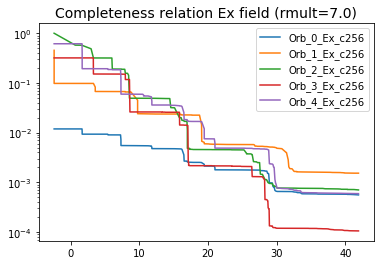

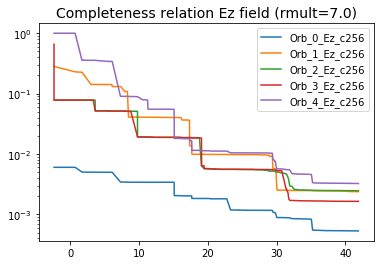

In [11]:
reload(R)
e_v_c256 = [0.0, 0.0]
crEx_c256 = [0.0, 0.0]
crEz_c256 = [0.0, 0.0]
for r in range(len(rVal)):
    e_v_c256[r],crEx_c256[r],crEz_c256[r]=R.completeness_relation(CR_data[r])
    
r = 0
print 'rmult = §', rVal[r]

#%matplotlib inline
rhoPlot = False
R.crplot(e_v_c256[r],crEx_c256[r],'Ex field (rmult='+str(rVal[r])+')','Ex_c256',rhoPlot)
plt.show()
R.crplot(e_v_c256[r],crEz_c256[r],'Ez field (rmult='+str(rVal[r])+')','Ez_c256',rhoPlot)
plt.show()

## Computation of the virtual orbitals (from O(N) computation)
In this section of the notebook we will:

 * Create the states from a support function calculations. We perform linear computation both with and without and explicit electric field to test the effect of the polarization of the basis on the completeness relation 
 * Orthogonalize the empty states created in this way with respect to the occupied states of the cubic computation
 * Use the basis generated in such a way to express the completeness relation
 
$\textbf{We perform this computation for rmult = 7.0}$.

In [12]:
inp=Yaml.load(stream=
"""
dft:
  hgrids: 0.4
  rmult: [7.0, 9.0]
import: linear #perform a O(N) calculation
lin_general: 
  subspace_diag: Yes #calculate the KS orbital in the support function basis
  extra_states: 2
lin_basis_params: 
  N: 
    nbasis: 23 #put 23 DoF per atom
    rloc: 10.0 
    rloc_kernel_foe: 12.5
ig_occupation: #create a s-p-d-f basis as a initial guess
 N:
  2s: 2 #1 
  2p: 3 #3
  3d: 0 #5
  4f: 0 #7
  3s: 0 #1
  3p: 0 #3
  4p: 0 #3
posinp:
   units                               : angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
output:
  orbitals: binary
  outputpsiid: virtuals
""")

inputon=deepcopy(inp)
inputon_pol=deepcopy(inp)

inputon['radical'] = 'Rmult7.0_on'
inputon_pol['dft']['elecfield'] = [0.0, 0.0, 0.01] # z-field
inputon_pol['radical'] = 'Rmult7.0_on_pol'

inpname = 'Rmult7.0_on'
inpname_pol = 'Rmult7.0_on_pol'
Yaml.dump(inputon,outputpathon + inpname + '.yaml')
Yaml.dump(inputon_pol,outputpathon + inpname_pol + '.yaml')

%cd $outputpathon
code.run(name=inpname,skip=True,outdir='./log/')
code.run(name=inpname_pol,skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals-on
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult7.0_on -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult7.0_on_pol -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


As the result of this computation 46 orbitals are written as "virtual" in the output folder (both with and without the electric field). Now we run a cubic computation to orthogonalize the linear scaling orbitals with respect to the occupied ones of the cubic computation

In [13]:
inpcubic=Yaml.load(stream="""
dft:
  hgrids: 0.4
  rmult: [7.0, 9.0]
  gnrm_cv: 1.e-8
  inputpsiid: 2 #read o(n) orbitals
  itermax_virt: 1 #do not optimize them
  norbv: -46 # use all the o(n) orbitals for empty states
posinp:
   units                               : angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
output:
  orbitals: binary
""")

inpcubic_ortho=deepcopy(inpcubic)
inpcubic_pol_ortho=deepcopy(inpcubic)

inpcubic_ortho['radical'] = 'Rmult7.0_on'
inpcubic_pol_ortho['radical'] = 'Rmult7.0_on_pol'

inpname = 'Rmult7.0_ortho'
inpname_pol = 'Rmult7.0_ortho_pol'

Yaml.dump(inpcubic_ortho,outputpathon + inpname + '.yaml')
Yaml.dump(inpcubic_pol_ortho,outputpathon + inpname_pol + '.yaml')

%cd $outputpathon
code.run(name=inpname,skip=True,outdir='./log/')
code.run(name=inpname_pol,skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals-on
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult7.0_ortho -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult7.0_ortho_pol -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


This computation has produced 5 occupied orbitals and 46 empty ones (orthogonal to the occupied set) 
Let us now inspect what is the modifications to the density of states that this orthogonalization implied

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


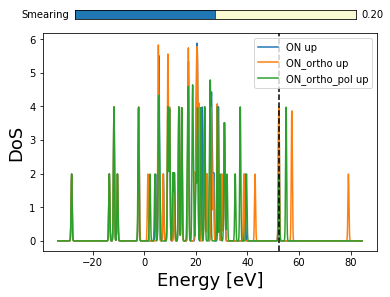

In [14]:
%matplotlib inline
on=lf.Logfile('virtual-orbitals-on/log/log-Rmult7.0_on.yaml',label='ON ')
on_ortho=lf.Logfile('virtual-orbitals-on/log/log-Rmult7.0_ortho.yaml')
on_ortho_pol=lf.Logfile('virtual-orbitals-on/log/log-Rmult7.0_ortho_pol.yaml')

dos=on.get_dos()
dos.append_from_bandarray(on_ortho.evals,label='ON_ortho ')
dos.append_from_bandarray(on_ortho_pol.evals,label='ON_ortho_pol ')
dos.plot()

We can then compare the density of states of the Orthogonalized ON basis functions with the one of the cubic approach with 256 states, considered as reference.

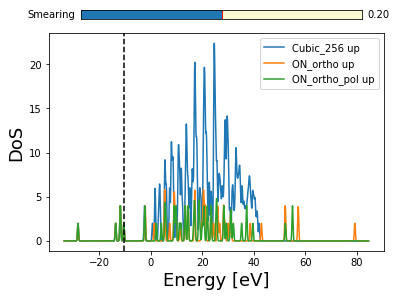

In [15]:
%matplotlib inline
cubic_256=lf.Logfile('virtual-orbitals/log/log-Rmult_7.0_numVirt_256.yaml',label='Cubic_256 ')
dos=cubic_256.get_dos()
dos.append_from_bandarray(on_ortho.evals,label='ON_ortho ')
dos.append_from_bandarray(on_ortho_pol.evals,label='ON_ortho_pol ')
dos.plot()

Here we can see that the basis set of the ON_ortho is higher in energy. It is also interesting to notice that the peaks of the dos somehow coincide.

## Expansion of the perturbed KS orbitals (O(N) code)

We write the input file and execute the computation for the study of the completeness relation of the basis built with the linear code

In [16]:
inputcubic_CR=Yaml.load(stream="""
dft:
  hgrids: 0.4
  rmult: [7.0, 9.0]
  gnrm_cv: 1.e-8
  inputpsiid: 2 #read o(n) orbitals
  itermax_virt: 1 #do not optimize them
  norbv: -46 # use all the o(n) orbitals for empty states
posinp:
   units                               : angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
#radical: Rmult7.0_on
""")
psip_Ex = '../static-field/log/data-Ex_1em2_rmult_7.0'
psip_Ez = '../static-field/log/data-Ez_1em2_rmult_7.0'

inpEx=deepcopy(inputcubic_CR)
inpEz=deepcopy(inputcubic_CR)
inpEx_pol=deepcopy(inputcubic_CR)
inpEz_pol=deepcopy(inputcubic_CR)

inpEx['tddft']={'decompose_perturbation': psip_Ex}
inpEx['radical'] = 'Rmult7.0_on'
inpEz['tddft']={'decompose_perturbation': psip_Ez}
inpEz['radical'] = 'Rmult7.0_on'
inpEx_pol['tddft']={'decompose_perturbation': psip_Ex}
inpEx_pol['radical'] = 'Rmult7.0_on_pol'
inpEz_pol['tddft']={'decompose_perturbation': psip_Ez}
inpEz_pol['radical'] = 'Rmult7.0_on_pol'

InpnameEx = 'CR_Ex_rmult_7.0_ortho'
InpnameEz = 'CR_Ez_rmult_7.0_ortho'
InpnameEx_pol = 'CR_Ex_rmult_7.0_ortho_pol'
InpnameEz_pol = 'CR_Ez_rmult_7.0_ortho_pol'

Yaml.dump(inpEx,outputpathon + InpnameEx + '.yaml')
Yaml.dump(inpEz,outputpathon + InpnameEz + '.yaml')
Yaml.dump(inpEx_pol,outputpathon + InpnameEx_pol + '.yaml')
Yaml.dump(inpEz_pol,outputpathon + InpnameEz_pol + '.yaml')

# execute the computations
%cd $outputpathon
code.run(name=InpnameEx,skip=True,outdir='./log/')
code.run(name=InpnameEz,skip=True,outdir='./log/')
code.run(name=InpnameEx_pol,skip=True,outdir='./log/')
code.run(name=InpnameEz_pol,skip=True,outdir='./log/')
%cd ../

# read the data
CR_data_ortho = []
CR_data_ortho_pol = []
%cd $outputpathon
spath = 'log/'+str('log-CR_E*_rmult_7.0_ortho.yaml') 
logs = !ls $spath
spath_pol = 'log/'+str('log-CR_E*_rmult_7.0_ortho_pol.yaml') 
logs_pol = !ls $spath_pol
CR_data_ortho.append([lf.Logfile(l) for l in logs])
CR_data_ortho_pol.append([lf.Logfile(l) for l in logs_pol])
%cd ..


/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals-on
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_ortho -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_ortho -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_ortho_pol -d ./log/ -s Yes
Executing command:  OMP_NUM_THREADS=2 mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_ortho_pol -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals-on
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We can here evaluate the completeness relation with the new basis.

no_occ 5 n_vrt 46
psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]
no_occ 5 n_vrt 46
psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]


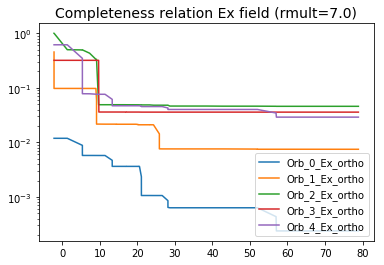

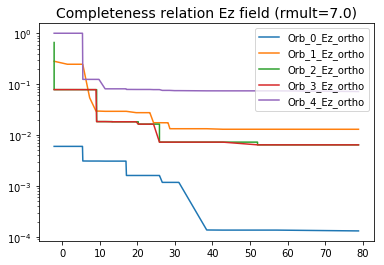

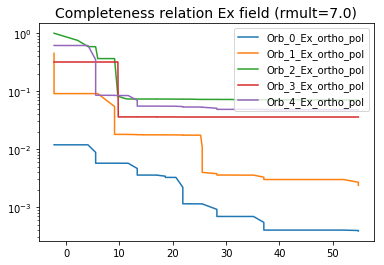

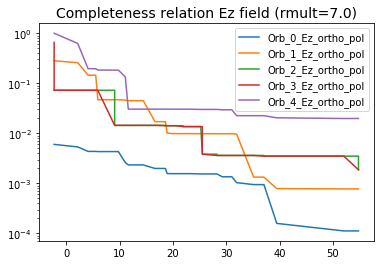

In [17]:
reload(R)
#%matplotlib inline
rhoPlot = False 
e_v_ortho,crEx_ortho,crEz_ortho=R.completeness_relation(CR_data_ortho[0])
e_v_ortho_pol,crEx_ortho_pol,crEz_ortho_pol=R.completeness_relation(CR_data_ortho_pol[0])

R.crplot(e_v_ortho,crEx_ortho,'Ex field (rmult=7.0)','Ex_ortho',rhoPlot)
plt.show()
R.crplot(e_v_ortho,crEz_ortho,'Ez field (rmult=7.0)','Ez_ortho',rhoPlot)
plt.show()
R.crplot(e_v_ortho_pol,crEx_ortho_pol,'Ex field (rmult=7.0)','Ex_ortho_pol',rhoPlot)
plt.show()
R.crplot(e_v_ortho_pol,crEz_ortho_pol,'Ez field (rmult=7.0)','Ez_ortho_pol',rhoPlot)
plt.show()

Let us now superimpose the plots with the ones of the cubic reference result

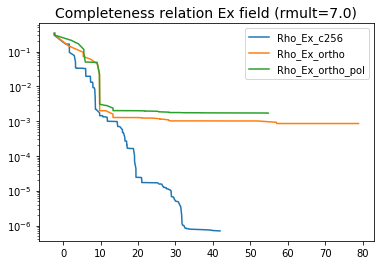

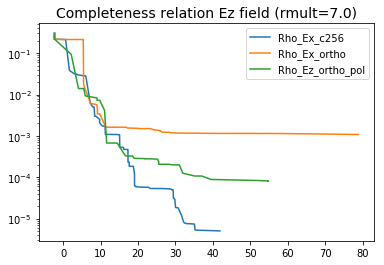

In [18]:
#%matplotlib inline
rhoPlot = True
R.crplot(e_v_c256[0],crEx_c256[0],'Ex field (rmult=7.0)','Ex_c256',rhoPlot)
R.crplot(e_v_ortho,crEx_ortho,'Ex field (rmult=7.0)','Ex_ortho',rhoPlot)
R.crplot(e_v_ortho_pol,crEx_ortho_pol,'Ex field (rmult=7.0)','Ex_ortho_pol',rhoPlot)
plt.show()

R.crplot(e_v_c256[0],crEz_c256[0],'Ez field (rmult=7.0)','Ex_c256',rhoPlot)
R.crplot(e_v_ortho,crEz_ortho,'Ez field (rmult=7.0)','Ex_ortho',rhoPlot)
R.crplot(e_v_ortho_pol,crEz_ortho_pol,'Ez field (rmult=7.0)','Ez_ortho_pol',rhoPlot)
plt.show()

We observe that the basis polarized (with an explicit field in the $z$ direction) provides improved results when
used to express the occupied orbitals of the system deformed in the same direction.